In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torchvision.models import resnet50, ResNet50_Weights
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
world_size = torch.cuda.device_count()
world_size

4

In [3]:
!pwd

/home/patel.devki1/Dataset


In [4]:
data_dir = '/home/patel.devki1/Dataset/lung_colon_image_set/'

In [5]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '13285'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)
    print(f"[Rank {rank}] Initialization complete. Using world size {world_size}.")

def cleanup():
    dist.destroy_process_group()

class LungColonCancerDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super(LungColonCancerDataset, self).__init__(root=root_dir, transform=transform)
        
def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.cuda()  # Assuming you're using GPU
            labels = labels.cuda()  # Assuming you're using GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

def plot_learning_curves(train_losses, valid_losses, valid_accuracies):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.show()

def train(rank, world_size, batch_size, num_workers):
    setup(rank, world_size)
    
    print(f"[Rank {rank}] Starting training...")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # training dataset
    train_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'train'), transform=transform)
    train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)  # num_workers
    
    # validation dataset
    validation_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'valid'), transform=transform)
    validation_sampler = DistributedSampler(validation_dataset, num_replicas=world_size, rank=rank)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, sampler=validation_sampler, num_workers=num_workers)  # num_workers
    
    # test dataset
    test_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'test'), transform=transform)
    test_sampler = DistributedSampler(test_dataset, num_replicas=world_size, rank=rank)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)  # num_workers
    
    print(f"[Rank {rank}] Loaded {len(train_dataset)} images for training.")

    # model = models.resnet50(pretrained=True)
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    num_ftrs = model.fc.in_features
    num_classes = 5
    model.fc = nn.Linear(num_ftrs, num_classes)  # 5 classes
    model = model.cuda(rank)
    ddp_model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])
    
    print(f"[Rank {rank}] Model initialized and wrapped in DDP.")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001, momentum=0.9)
    
    print(f"[Rank {rank}] Optimizer and loss function are set up.")

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    start_time = time.time()  # Start timing
    print("start_time", start_time)
    
    for epoch in range(10):  # Adjust the number of epochs
        epoch_start_time = time.time()  # Start time for the epoch
        ddp_model.train()
        epoch_train_losses = []
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.cuda(rank)
            labels = labels.cuda(rank)

            optimizer.zero_grad()
            outputs = ddp_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

            if batch_idx % 10 == 0:  # Log every 10 batches
                print(f"[Rank {rank}] Epoch {epoch+1} Batch {batch_idx+1}: Loss {loss.item()}")

        train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))

        epoch_duration = time.time() - epoch_start_time  # Calculate duration of the epoch
        print(f"Each Epoch Duration {epoch_duration}")
        
        # Validation
        print("Validation Results:")
        valid_loss, valid_accuracy, _, _ = evaluate(model, validation_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plot_learning_curves(train_losses, valid_losses, valid_accuracies)

    print("Test Results:")
    test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader)

    cleanup()
    
    end_time = time.time()  # End timing
    print("total end_time", end_time)
    
    duration = end_time - start_time
    print(f"Rank {rank}: Training duration: {duration:.2f} seconds")
    
    # saving the model for later use without disturbing the rest of the code
    torch.save(model.state_dict(), 'lung_colon_cancer_model.pth')
    
    # return the model to use for other evaluations
    return model

[Rank 0] Initialization complete. Using world size 2.
[Rank 0] Starting training...
[Rank 0] Loaded 20000 images for training.
[Rank 1] Initialization complete. Using world size 2.
[Rank 1] Starting training...
[Rank 1] Loaded 20000 images for training.
[Rank 0] Model initialized and wrapped in DDP.
[Rank 0] Optimizer and loss function are set up.
start_time 1713127044.8733048
[Rank 1] Model initialized and wrapped in DDP.
[Rank 1] Optimizer and loss function are set up.
start_time 1713127044.9264061
[Rank 0] Epoch 1 Batch 1: Loss 1.6218442916870117[Rank 1] Epoch 1 Batch 1: Loss 1.6174845695495605

Each Epoch Duration 25.312238216400146
Validation Results:
Each Epoch Duration 25.28242063522339
Validation Results:
Accuracy: 0.4128
Precision: 0.4154
Recall: 0.4126
F1 Score: 0.3895
Accuracy: 0.3888
Precision: 0.3851
Recall: 0.3888
F1 Score: 0.3616
[Rank 1] Epoch 2 Batch 1: Loss 1.4941444396972656[Rank 0] Epoch 2 Batch 1: Loss 1.4952266216278076

Each Epoch Duration 23.624682664871216
Vali

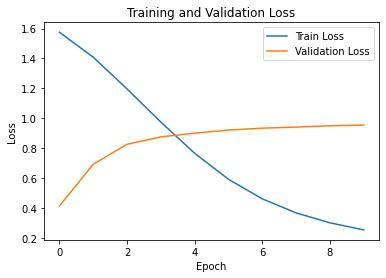

Accuracy: 0.9416
Precision: 0.9412
Recall: 0.9412
F1 Score: 0.9411


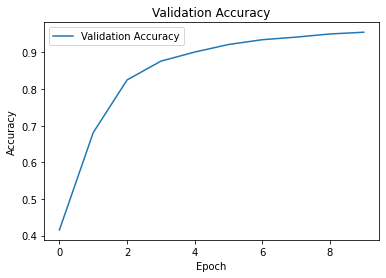

Test Results:


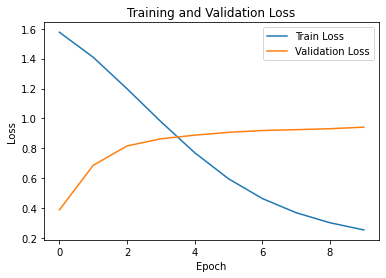

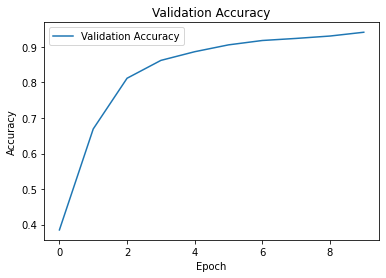

Test Results:
Accuracy: 0.9424
Precision: 0.9432
Recall: 0.9430
F1 Score: 0.9430
total end_time 1713127409.1857884
Rank 1: Training duration: 364.26 seconds
Accuracy: 0.9320
Precision: 0.9329
Recall: 0.9315
F1 Score: 0.9320
total end_time 1713127409.9965136
Rank 0: Training duration: 365.12 seconds


In [6]:
if __name__ == '__main__':
    world_size = 2
    num_workers = 8
    batch_size = 1000
    processes = []
    for rank in range(world_size):
        p = mp.Process(target=train, args=(rank, world_size, batch_size, num_workers))
        p.start() 
        processes.append(p)
    for p in processes:
        p.join()

Conclusion:

Epoch 1:  18.61301279067993 seconds

Epoch 2:  17.631513118993895 seconds

Epoch 3:  17.477299261432647 seconds

Epoch 4:  17.74317854642868 seconds

Epoch 5:  17.365439891815185 seconds

Epoch 6:  17.218110919248717 seconds

Epoch 7:  17.70451444387436 seconds

Epoch 8:  17.933776140213014 seconds

Epoch 9:  17.475732147693634 seconds

Epoch 10: 18.3057804107666 seconds

Average duration for each epoch ≈ 17.78 seconds